# 0.0 IMPORTS

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt

import warnings
import random as r
import pickle

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate
from IPython.display import Image
from IPython.display import display, HTML

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## 0.1 Helper Functions

In [51]:
def jupyter_settings():
    %matplotlib inline
#     %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 30
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()
# warnings.filterwarnings( 'ignore' )
display(HTML("<style>.container { width:70% !important; }</style>"))

def precision_at_k( data, k=2000 ):
    # sort clients by propensity score
    data = data.sort_values( 'score', ascending=False )

    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Column
    data['ranking'] = data.index + 1

    # Precision@k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    # sort clients by propensity score
    data = data.sort_values( 'score', ascending=False )
    
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking Column
    data['ranking'] = data.index + 1

    # Precision@k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

def cross_validation( x_training, kfold, model_name, model, at_k, verbose=False ):
    cols_selected = [ 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured' ]
    precision_at_k_list = []
    recall_at_k_list = []
    for k in range( 1, kfold+1 ):
        if verbose:
            print( f'\nKFold Number: {k}' )
        # Start and end date for validation
        fold_rows = int(x_training.shape[0] / kfold) - 1
        
        validation_start = fold_rows * k - fold_rows
        validation_end = fold_rows * k

        # Filtering Dataset
        training1 = x_training.iloc[0:validation_start-1, :]
        training2 = x_training.iloc[validation_end+1::, :]
        training = pd.concat( [training1, training2] )
        validation = x_training.iloc[validation_start:validation_end, :]

        # Training Dataset
        xtraining = training[cols_selected]
        ytraining = training['response']

        # Validation Dataset
        xvalidation = validation[cols_selected]
        yvalidation = validation['response']

        # Model
        m = model.fit( xtraining, ytraining )


        # Prediction
        yhat = m.predict_proba( xvalidation )


        # Performance
        df_metrics = xvalidation.copy()
        df_metrics['response'] = yvalidation.copy()
        df_metrics['score'] = yhat[:, 1].tolist()
        
        k1 = at_k
        precision = precision_at_k( df_metrics, k=k1 )
        recall = recall_at_k( df_metrics, k=k1 )
        
        m_result = pd.DataFrame( { 'Model Name': model_name,
                                   'PRECISION CV': precision,
                                   'RECALL CV': recall}, index=[0] )

        # Store performance of each kfold iteration
        precision_at_k_list.append(  m_result['PRECISION CV'] )
        recall_at_k_list.append( m_result['RECALL CV'] )

    return pd.DataFrame( {'Model Name': model_name, 
                          'PRECISION CV': np.round( np.mean( precision_at_k_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( precision_at_k_list ), 4 ).astype( str ), 
                          'RECALL CV': np.round( np.mean( recall_at_k_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( recall_at_k_list ), 4 ).astype( str )}, index=[0] )

def annot_max(x, y, xytext1, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.0f}, y={:.0f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="<|-|>",connectionstyle='arc3,rad=-0.5', color='black')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext1, **kw)

## 0.2 Load Data

In [52]:
df_raw = pd.read_csv( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/data/raw/train.csv' )

In [53]:
pwd

'/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/notebooks'

# 1.0 STEP 01 - DATA DESCRIPTION

In [54]:
df1 = df_raw.copy()

## 1.1 Columns Description

In [55]:
tab_meanings = [['Column', 'Meaning'],
        ['id', 'unique customer identifier.'],
        ['gender', 'client gender: Male / Female.'],
        ['age', 'customer age.'],
        ['region_code', 'customer region code.'],
        ['policy_sales_channel', 'Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..'],
        ['driving_license', '0 = customer does not have DL, 1 = already have DL'],
        ['vehicle_age', 'vehicle age: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = customer has never had their vehicle damaged in the past, Yes = has had it.'],
        ['vehicle_prev_insured', '0 = customer does not have vehicle insurance, 1= already has vehicle insurance.'],
        ['health_annual_premium', 'annual amount paid by the customer to the company for health insurance. Currency: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],
        ['days_associated', 'number of days since the customer joined the company by purchasing health insurance. The policy is annual.'],
        ['response', '0 = customer is not interested, 1 = customer is interested.']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='rst'))

=====================  =========================================================================================================================
Column                 Meaning
=====================  =========================================================================================================================
id                     unique customer identifier.
gender                 client gender: Male / Female.
age                    customer age.
region_code            customer region code.
policy_sales_channel   Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..
driving_license        0 = customer does not have DL, 1 = already have DL
vehicle_age            vehicle age: < 1 Year, 1-2 Year, > 2 Years
vehicle_damage         No = customer has never had their vehicle damaged in the past, Yes = has had it.
vehicle_prev_insured   0 = customer does not have vehicle insurance, 1= already has vehicle insurance.
health_annual_p

### 1.1.1 Columns Exemple

In [56]:
df1.head()

,id,previously_insured,annual_premium,vintage,response,id.1,gender,age,region_code,policy_sales_channel,id.2,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes
1,13,1,31409.0,221,0,13,Female,41,15.0,14.0,13,1,1-2 Year,No
2,18,1,46622.0,299,0,18,Female,25,35.0,152.0,18,1,< 1 Year,No
3,31,0,2630.0,136,0,31,Female,26,8.0,160.0,31,1,< 1 Year,No
4,39,0,42297.0,264,0,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes


## 1.2 Data Dimensions

In [57]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Cols: {df1.shape[1]}' )

Number of Rows: 381109
Number of Cols: 14


## 1.3 Data Types

In [58]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
id.1                      int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
id.2                      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.4 Check NA's

In [59]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
id.1                    0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
id.2                    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.5 Fill NA's

In [60]:
# Not Necessary

## 1.6 Change Types

In [61]:
df1['region_code'] = df1['region_code'].astype( int )

In [62]:
# Check Change
df1['region_code'].dtypes

dtype('int64')

## 1.7 Drop Columns

In [63]:
if 'id.1'  in df1.columns:
    df1 = df1.drop( columns='id.1' )
else:
    pass

if 'id.2'  in df1.columns:
    df1 = df1.drop( columns='id.2' )
else:
    pass

## 1.8 Descriptive Statistics

In [64]:
num_attributes = df1.select_dtypes( include=['int64', np.float64] )
cat_attributes = df1.select_dtypes( exclude=['int64', np.float64] )

### 1.8.1 Numerical Attributes

In [65]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, min, max, range, skewness, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [66]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
2,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
3,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
4,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
5,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
6,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302


### 1.8.2 Categorical Attributes

In [67]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:xlabel='vehicle_age', ylabel='id'>

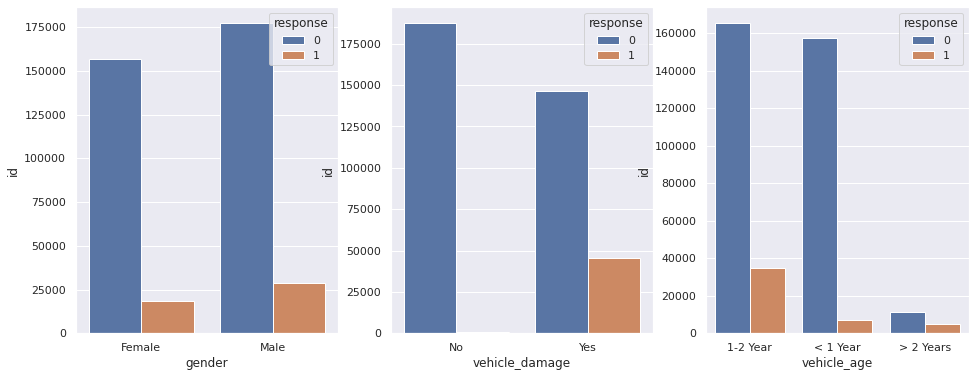

In [68]:
aux = df1.copy()

plt.figure( figsize=(16, 6) )

# Graph 1 - Gender
plt.subplot( 131 )
aux1 = aux[['gender', 'response', 'id']].groupby( ['gender', 'response'] ).count().reset_index()
sns.barplot( x='gender', y='id', hue='response', data=aux1 )


# Graph 2 - Vehicle Damage
plt.subplot( 132 )
aux1 = aux[['vehicle_damage', 'response', 'id']].groupby( ['vehicle_damage', 'response'] ).count().reset_index()
sns.barplot( x='vehicle_damage', y='id', hue='response', data=aux1 )


# Graph 3 - Vehicle Age
plt.subplot( 133 )
aux1 = aux[['vehicle_age', 'response', 'id']].groupby( ['vehicle_age', 'response'] ).count().reset_index()
sns.barplot( x='vehicle_age', y='id', hue='response', data=aux1 )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [69]:
df2 = df1.copy()

## 2.1 Hypothesis Mindmap

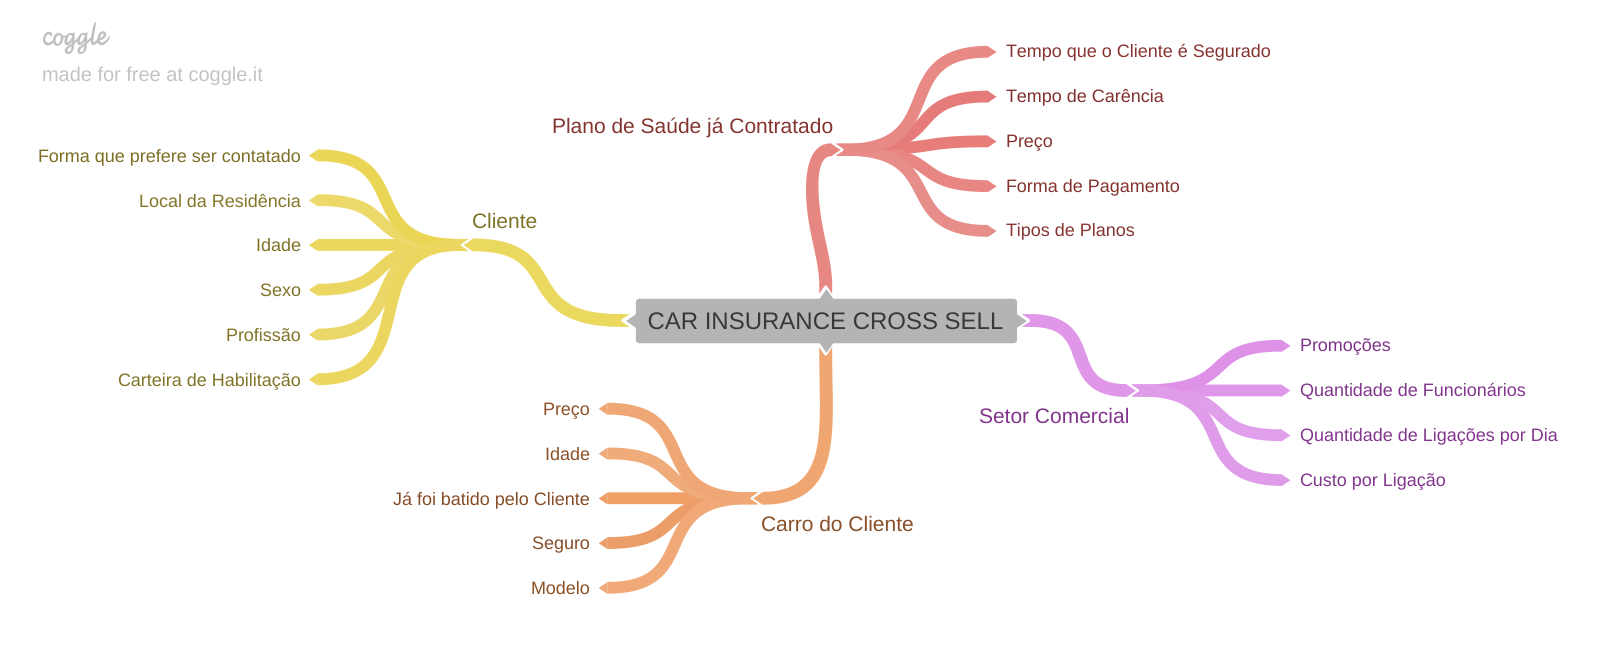

In [70]:
Image( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/img/mindmap_hypothesis_cross_sell.png' )

## 2.2 Hypothesis Creating

### 2.2.1 Client Hypotheses

**1.** Clientes com maior idade compram mais seguro de carro.

**2.** Clientes do sexo feminino compra mais seguro de carro.

### 2.2.2 Car Hypotheses

**1.** Carros mais velhos possuem menos seguros de carro.

**2.** Carros que nunca foram batidos possuem menos seguro de carro.

### 2.2.3 Health Insurance Hypotheses

**1.** Clientes com planos de saúde mais caros, comprar mais seguro de carro.

**2.** Clientes que são segurados a mais tempo pelo plano de saúde, compram mais o seguro de carro.

### 2.2.4 Hypotheses Final List

**1.** Clientes com maior idade compram mais seguro de carro.

**2.** Clientes do sexo feminino compra mais seguro de carro.

**3.** Carros mais velhos possuem menos seguros de carro.

**4.** Carros que nunca foram batidos possuem menos seguro de carro.

**5.** Clientes com planos de saúde mais caros, comprar mais seguro de carro.

**6.** Clientes que são segurados a mais tempo pelo plano de saúde, compram mais o seguro de carro.

## 2.3 Feature Engineering

In [71]:
# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'below_1_year' if x == '< 1 Year' else 
                                                         'between_1_2_year' if x == '1-2 Year' else 
                                                         'over_2_years' )

# 3.0 STEP 03 - DATA FILTERING

In [72]:
df3 = df2.copy()

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [73]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [74]:
df4.columns

Index(['id', 'previously_insured', 'annual_premium', 'vintage', 'response',
       'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

### 4.1.1 Response Variable

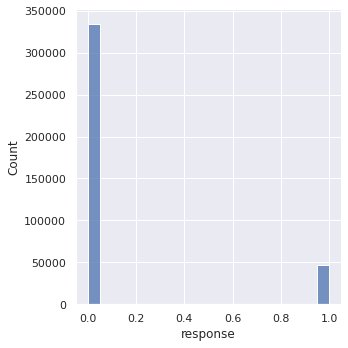

In [75]:
sns.displot( df4['response'] )

### 4.1.2 Age

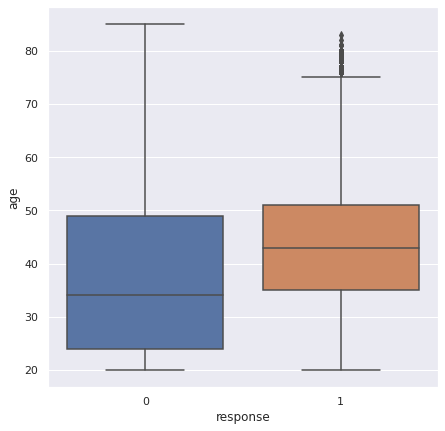

In [76]:
# age
sns.set(rc={'figure.figsize':(7, 7)})
sns.boxplot( x='response', y='age', data=df4 );

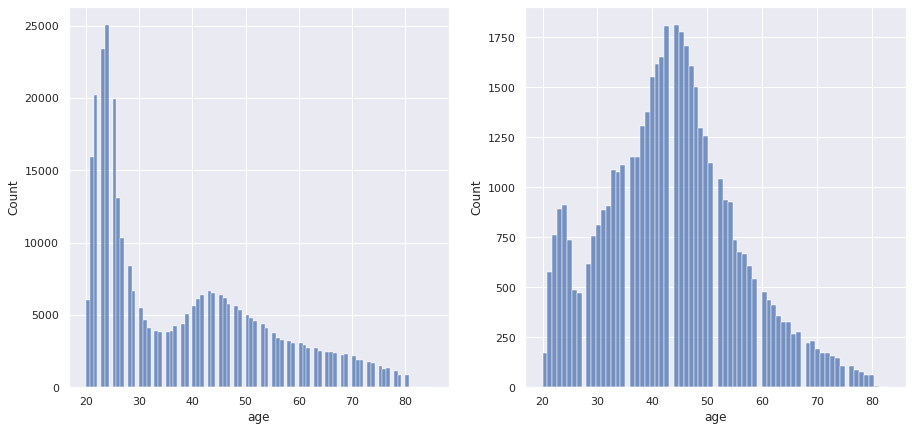

In [77]:
# Plot size
sns.set(rc={'figure.figsize':(15, 7)})

# Graph 1 - 'No'
plt.subplot( 121 )
aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux1 );

# Graph 2 - 'Yes'
plt.subplot( 122 )
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux1 );

### 4.1.3 Annual Premium

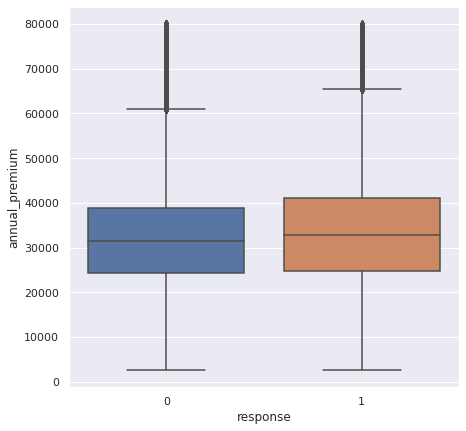

In [78]:
# annual_premium
sns.set(rc={'figure.figsize':(7, 7)})
aux1 = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux1 );

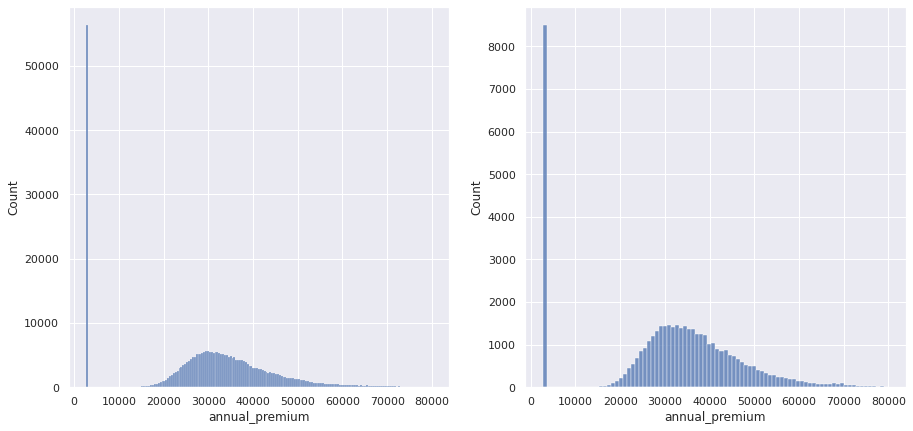

In [79]:
# Plot size
sns.set(rc={'figure.figsize':(15, 7)})

# Graph 1 - 'No'
plt.subplot( 121 )
aux2 = aux1.loc[aux1['response'] == 0, 'annual_premium']
sns.histplot( aux2 );

# Graph 2 - 'Yes'
plt.subplot( 122 )
aux3 = aux1.loc[aux1['response'] == 1, 'annual_premium']
sns.histplot( aux3 );

### 4.1.4 Driving License

In [80]:
# driving_license
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,driving_license_perc
0,7,0,23367.0,249,0,Male,23,11,152.0,1,< 1 Year,Yes,0.000003
1,13,1,31409.0,221,0,Female,41,15,14.0,1,1-2 Year,No,0.000003
2,18,1,46622.0,299,0,Female,25,35,152.0,1,< 1 Year,No,0.000003
3,31,0,2630.0,136,0,Female,26,8,160.0,1,< 1 Year,No,0.000003
4,39,0,42297.0,264,0,Male,45,8,124.0,1,1-2 Year,Yes,0.000003


<AxesSubplot:xlabel='response', ylabel='driving_license'>

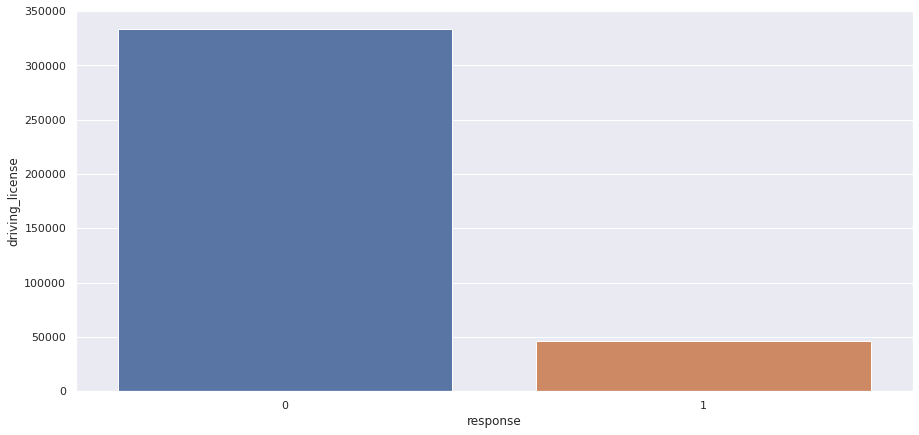

In [81]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux )

### 4.1.5 Region Code

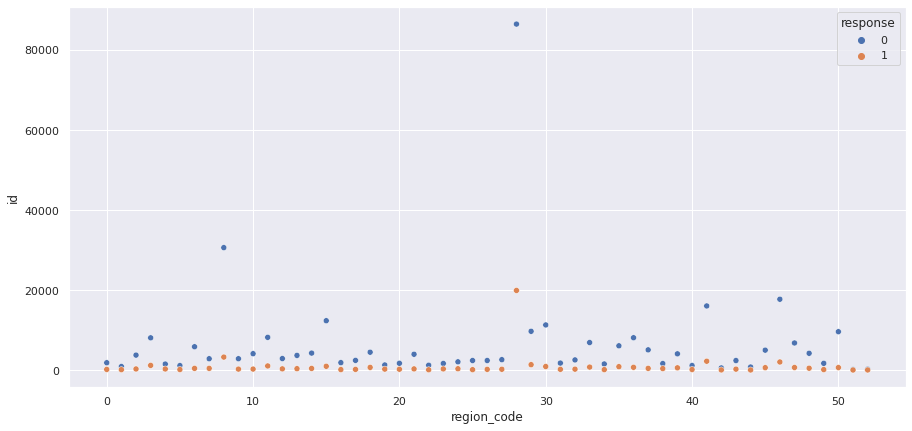

In [82]:
# region_code
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 );

### 4.1.6 Previously Insured

In [83]:
# previously insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.7 Vehicle Age

In [84]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


### 4.1.8 Policy Sales Channel

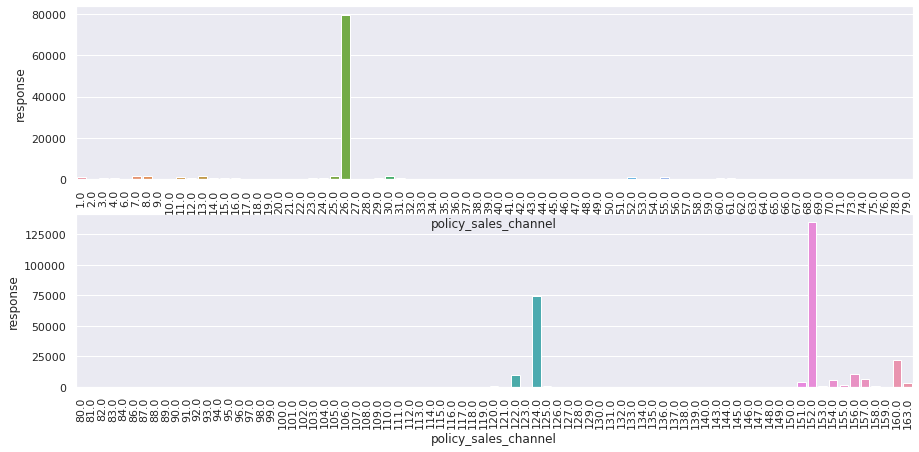

In [85]:
plt.subplot( 212 )
aux1 = df4[df4['policy_sales_channel'] >= 80.0].groupby( 'policy_sales_channel' )['response'].count().reset_index()
sns.barplot( x='policy_sales_channel', y='response', data=aux1 )
plt.xticks(rotation=90);

plt.subplot( 211 )
aux2 = df4[df4['policy_sales_channel'] < 80.0].groupby( 'policy_sales_channel' )['response'].count().reset_index()
sns.barplot( x='policy_sales_channel', y='response', data=aux2 )
plt.xticks(rotation=90);

In [86]:
# Select Columns and Policy Sales Channel <= 80
aux1 = df4[df4['policy_sales_channel'] <= 80][['response', 'policy_sales_channel']]
aux1['policy_sales_channel'] = aux1['policy_sales_channel'].astype( 'int' )



# Response Percentage by Policy Sales Channel
cross_tab_prop1 = pd.crosstab( index=aux1['policy_sales_channel'],
                              columns=aux1['response'],
                              normalize="index" )

# =========================================================================================================

# Select Columns and Policy Sales Channel > 80
aux2 = df4[df4['policy_sales_channel'] > 80][['response', 'policy_sales_channel']]
aux2['policy_sales_channel'] = aux2['policy_sales_channel'].astype( 'int' )

# Response Percentage by Policy Sales Channel
cross_tab_prop2 = pd.crosstab( index=aux2['policy_sales_channel'],
                              columns=aux2['response'],
                              normalize="index" )

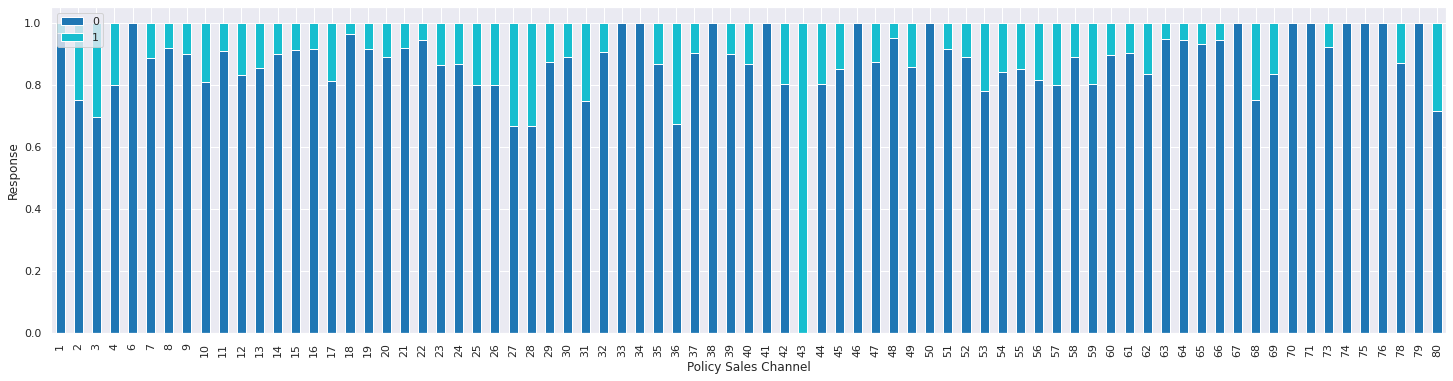

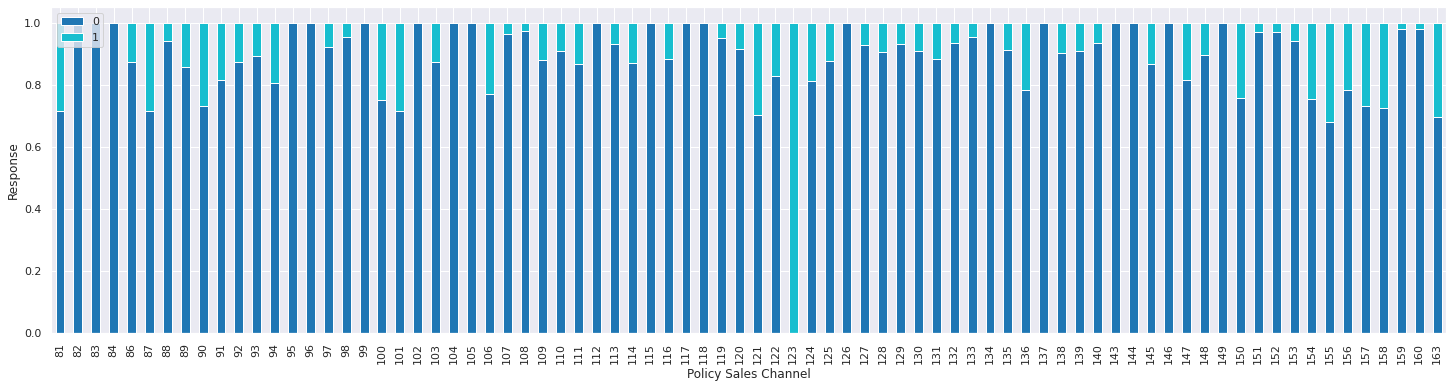

In [87]:
# Graph 1 - Policy Sales Channel <= 80
# plt.subplot( 211 )
cross_tab_prop1.plot( kind='bar',
                     stacked=True,
                     colormap='tab10',
                     figsize=(25, 6))

plt.legend( loc='upper left', ncol=1 )
plt.xlabel( 'Policy Sales Channel' )
plt.ylabel( 'Response' )
plt.xticks( rotation=90 )
plt.show()

# Graph 2 - Policy Sales Channel > 80
# plt.subplot( 212 )
cross_tab_prop2.plot( kind='bar',
                     stacked=True,
                     colormap='tab10',
                     figsize=(25, 6))

plt.legend( loc='upper left', ncol=1 )
plt.xlabel( 'Policy Sales Channel' )
plt.ylabel( 'Response' )
plt.xticks( rotation=90 )
plt.show()

### 4.1.9 Vintage

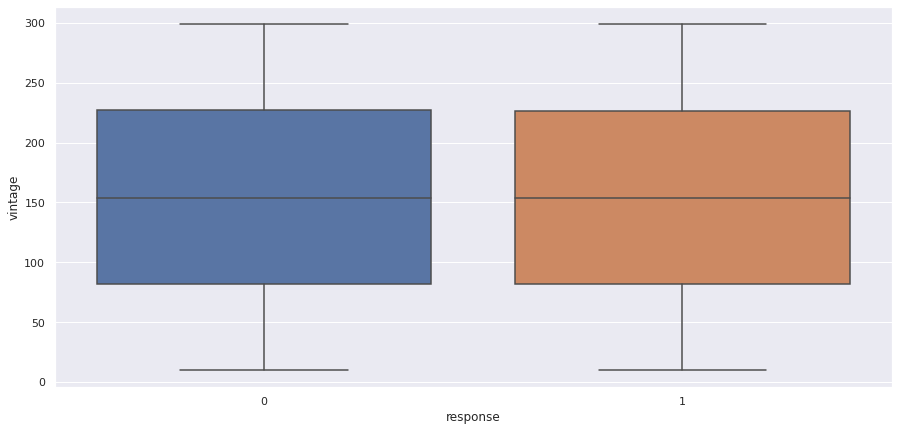

In [88]:
# vintage
sns.boxplot( x='response', y='vintage', data=df4 );

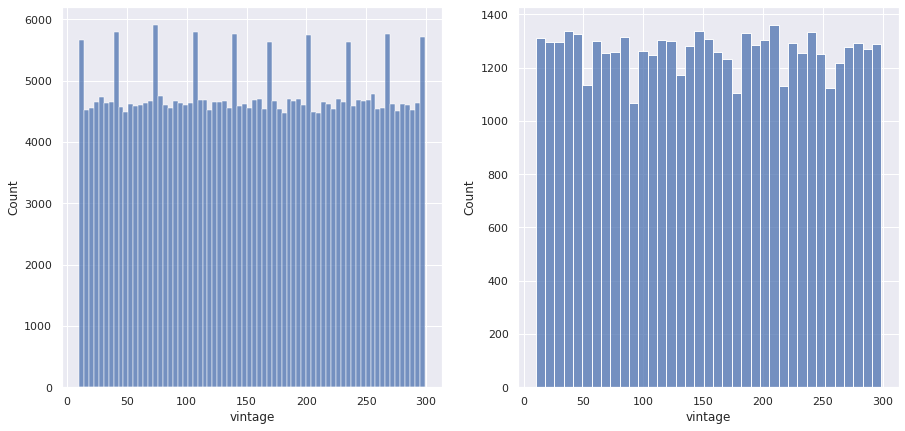

In [89]:
# Graph 1 - Dist of Response = No
plt.subplot( 121 )
aux1 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux1 );

# Graph 1 - Dist of Response = Yes
plt.subplot( 122 )
aux2 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux2 );

## 4.2 Bivariate Analysis

### **1.** Clientes com maior idade compram mais seguros de carro.

**VERDADEIRA** Clientes com maior idade compram mais seguros de carro até a idade de 44 anos.

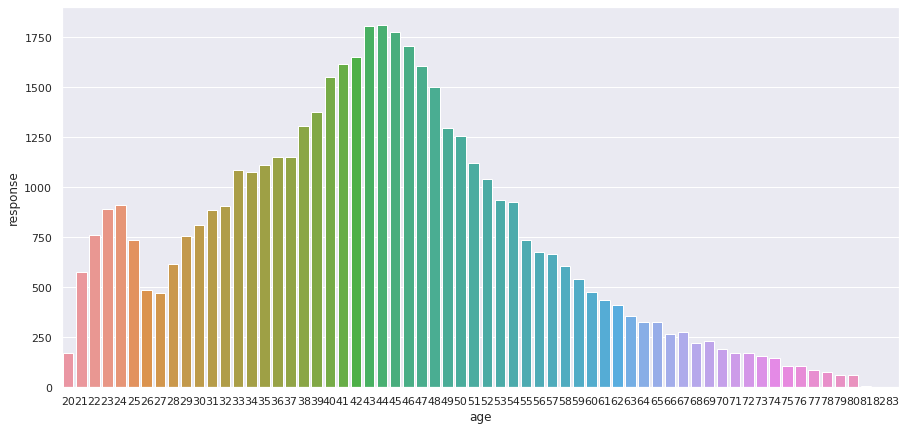

In [90]:
aux1 = df4[df4['response'] == 1]
aux2 = aux1[['response', 'age']].groupby( 'age' ).count().reset_index()
sns.barplot( x='age', y='response', data=aux2 );

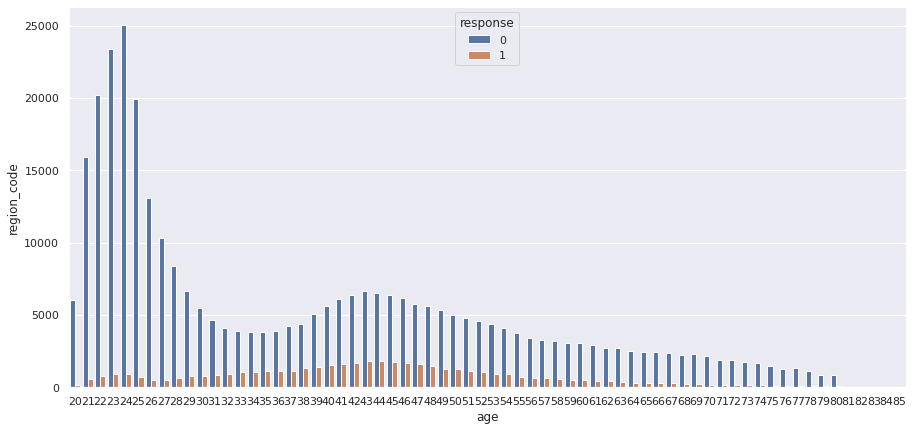

In [91]:
aux3 = df4[['response', 'age', 'region_code']].groupby( ['response', 'age'] ).count().reset_index()
sns.barplot( x='age', y='region_code', hue='response', data=aux3 );

### **2.** Clientes do gênero feminino compram mais seguros de carro.

**FALSA** Clientes do gênero feminino compram menos seguros do que do gênero masculino.

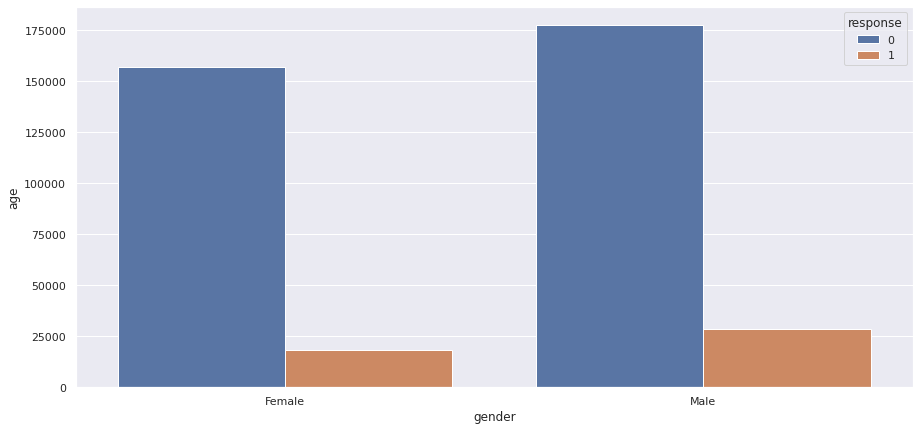

In [92]:
aux00 = df4[['response', 'gender', 'age']].groupby( ['gender', 'response'] ).count().reset_index()
sns.barplot( x='gender', y='age', hue='response', data=aux00 );

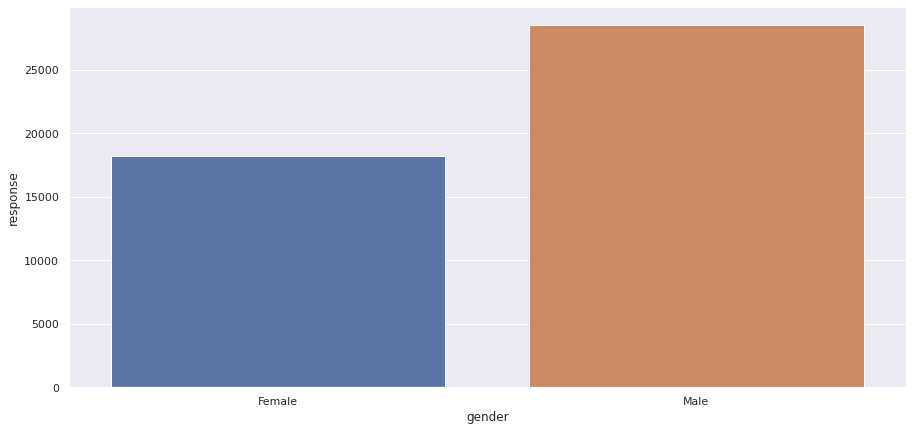

In [93]:
aux1 = df4[df4['response'] == 1]
aux2 = aux1[['response', 'gender']].groupby( 'gender' ).count().reset_index()
sns.barplot( x='gender', y='response', data=aux2 );

### **3.** Carros mais velhos possuem menos seguros de carro.

**VERDADEIRA** Apesar de ter uma menor quantidade de dados referentes aos carros mais velhos, em valores brutos eles realmente são os que possuem a menor quantidade de seguros. E ao contrário do que se imaginava com a hipótese de que os carros mais novos seriam os com maior quantidade de seguros, na verdade os carros com idade entre 1 e 2 foram os que tiverem a maior quantidade de seguros.

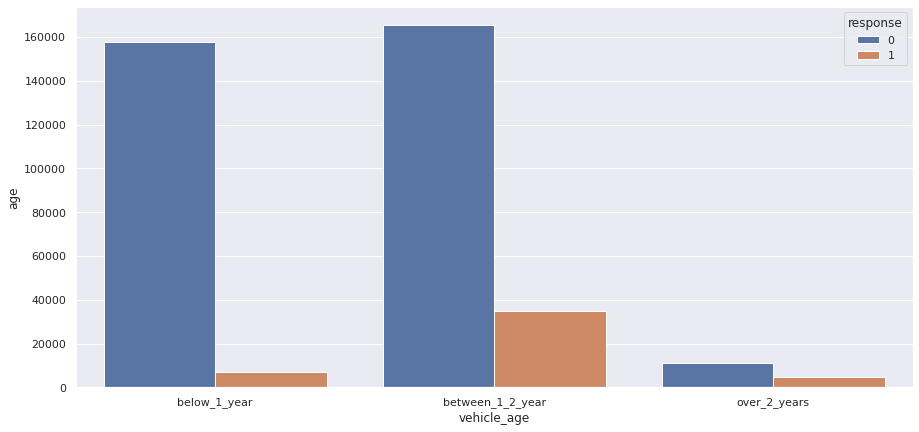

In [94]:
aux1 = df4[['response', 'vehicle_age', 'age']].groupby( ['vehicle_age', 'response'] ).count().reset_index()
sns.barplot( x='vehicle_age', y='age', hue='response', data=aux1 );

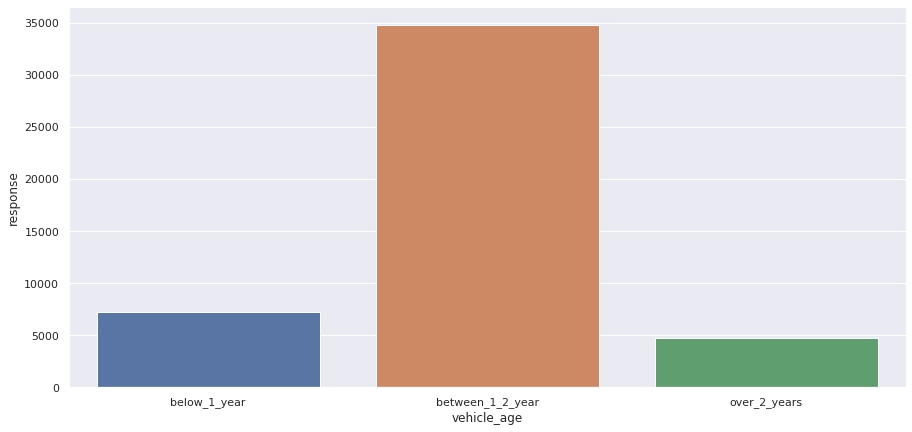

In [95]:
aux1 = df4[df4['response'] == 1]
aux2 = aux1[['response', 'vehicle_age']].groupby( 'vehicle_age' ).count().reset_index()
sns.barplot( x='vehicle_age', y='response', data=aux2 );

### **4.** Carros que nunca foram batidos possuem menos seguros de carro.

**VERDADEIRA** Clientes que nunca bateram o carro praticamente nunca compram um seguro de carro.

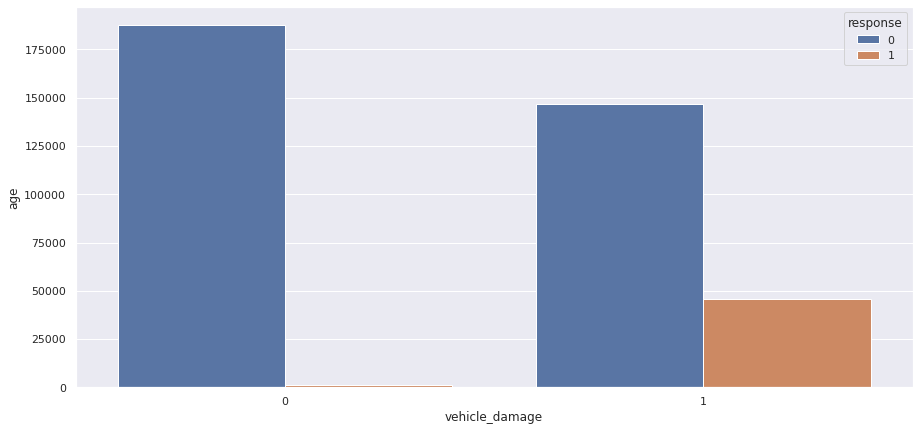

In [96]:
aux1 = df4[['response', 'vehicle_damage', 'age']].groupby( ['vehicle_damage', 'response'] ).count().reset_index()
sns.barplot( x='vehicle_damage', y='age', hue='response', data=aux1 );

### **5.** Clientes com planos de saúde mais caros, compram mais seguros de carro.

**FALSA** A maior concentração de clientes que compram seguros de carros está entre os clientes que pagam os menores valores de planos de saúde.

/tmp/ipykernel_359/3259132350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['annual_premium_binned'] = pd.cut( aux1['annual_premium'], bins=bins )


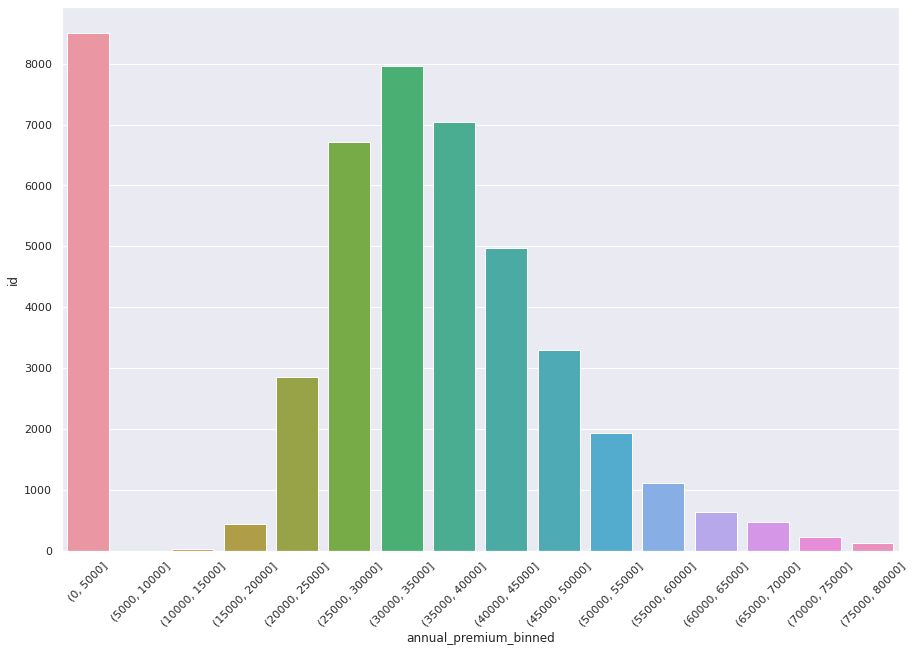

In [97]:
plt.figure(figsize=(15,10))
aux1 = df4[df4['response'] == 1]
bins = list( np.arange( 0, 85000, 5000 ) )
aux1['annual_premium_binned'] = pd.cut( aux1['annual_premium'], bins=bins )
aux2 = aux1[['annual_premium_binned', 'id']].groupby( 'annual_premium_binned' ).count().reset_index()

sns.barplot( x='annual_premium_binned', y='id', data=aux2 );
plt.xticks( rotation=45 );

### **6.** Clientes que são segurados a mais tempo pelo plano de saúde, compram mais seguros de carro.
**FALSA** A quantidade de clientes que compram seguros de carro se mantém praticamente a mesma ao longo do tempo de plano de saúde.

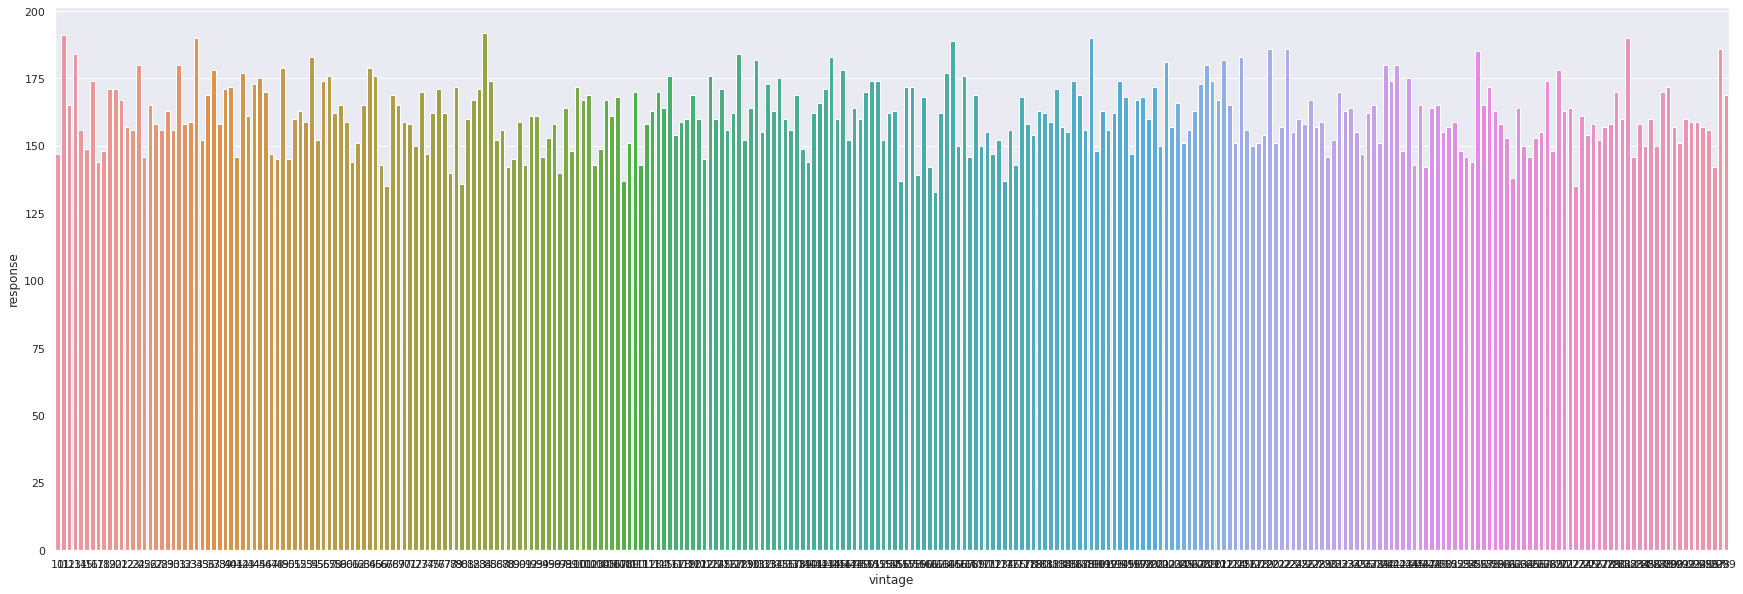

In [98]:
plt.figure(figsize=(30,10))
aux1 = df4[df4['response'] == 1]
aux2 = aux1[['response', 'vintage']].groupby( 'vintage' ).count().reset_index()
sns.barplot( x='vintage', y='response', data=aux2 );

## 4.2 Multivariate Analysis

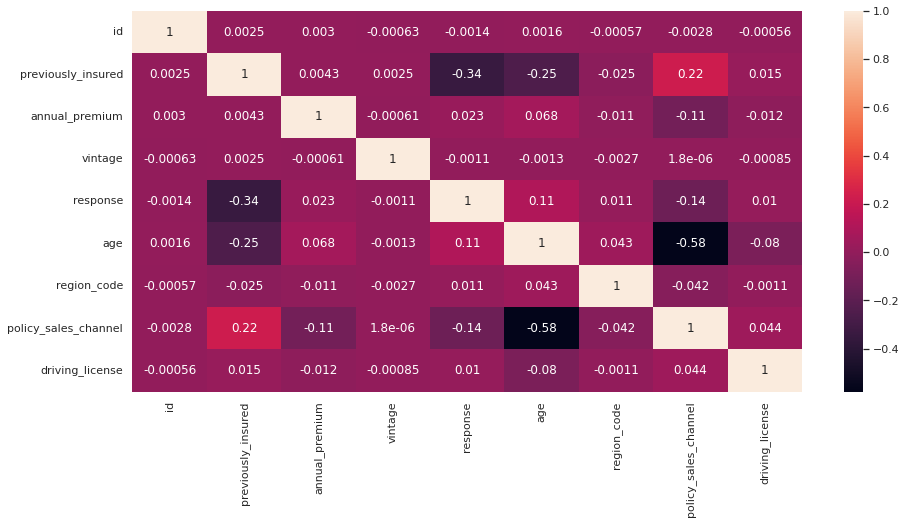

In [99]:
num_atributes = df4.select_dtypes( include=['int64', 'float64'] )
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0 STEP 05 - DATA PREPARATION

In [100]:
df5 = df4.copy()

In [101]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [102]:
# x_validation.to_csv( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/data/validation/validation.csv', index=False )

## 5.1 Standardization

In [103]:
ss = pp.StandardScaler()

# Annual Premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

# Saving Annual Premium Standardization
pickle.dump( ss, open( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2 Rescaling 

In [104]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# Saving Age Scaler
pickle.dump( mms_age, open( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/src/features/age_scaler.pkl', 'wb' ) )

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

# Saving Vintage Scaler
pickle.dump( mms_vintage, open( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/src/features/vintage_scaler.pkl', 'wb' ) )

## 5.3 Encoder

In [105]:
# region_code - target encoding / frequency encoding / weighted target encoding
target_encoding_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encoding_region_code )

# Saving Region Code Encoder
pickle.dump( target_encoding_region_code, open( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/src/features/target_encoding_region_code_scaler.pkl', 'wb' ) )

In [106]:
# Gender - One Hot encoding / Target encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# Saving Gender Encoding
pickle.dump( target_encode_gender, open( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/src/features/target_encode_gender_scaler.pkl', 'wb' ) )

In [107]:
# vehicle_age - one hot encoding / frequency encoding / order encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

In [108]:
# policy_sales_channel - Target encoding / frequency encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

# Saving Policy Sales Channel Encoding
pickle.dump( fe_policy_sales_channel, open( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4 Validation Preparation

In [109]:
# Gender - One Hot encoding / Target encoding
x_validation.loc[:, 'gender'] = x_validation['gender'].map( target_encode_gender )

# Annual Premium
x_validation['annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values )

# Age
x_validation['age'] = mms_age.fit_transform( x_validation[['age']].values )

# Vintage
x_validation['vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )

# region_code - target encoding / frequency encoding / weighted target encoding
x_validation.loc[:, 'region_code'] = x_validation['region_code'].map( target_encoding_region_code )

# vehicle_age - one hot encoding / frequency encoding / order encoding
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target encoding / frequency encoding
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0 STEP 06 - FEATURE SELECTION

In [110]:
# Model Definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# Data Preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                        feature  importance
0                       vintage    0.274997
0                annual_premium    0.245145
0                           age    0.164667
0                   region_code    0.103428
0                vehicle_damage    0.072465
0          policy_sales_channel    0.061279
0            previously_insured    0.049167
0      vehicle_age_below_1_year    0.014849
0  vehicle_age_between_1_2_year    0.006140
0                        gender    0.005117
0      vehicle_age_over_2_years    0.002273
0               driving_license    0.000473


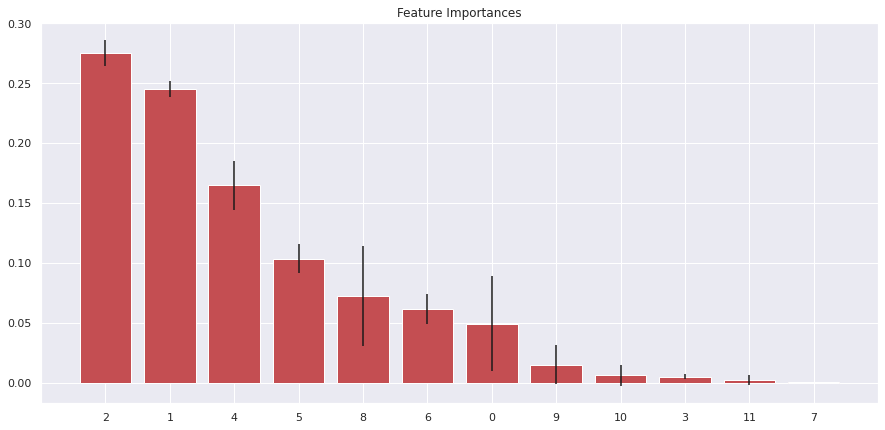

In [111]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# Print de Feature Ranking
print( 'Feature Ranking:' )
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( { 'feature': i, 'importance': j }, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title( 'Feature Importances' )
plt.bar( range( x_train_n.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range( x_train_n.shape[1] ), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

# 7.0 STEP 07 - MACHINE LEARNING MODELLING

In [144]:
cols_selected = [ 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured' ]

# Cross_validation Df 
x_training = df5.copy()

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

# DataFrame for Precision@k and Recall@k
df7 = x_validation.copy()
# Response Variable
df7['response'] = y_validation.copy()

## 7.1 Baseline 

Precision at 20000: 0.12584370781460927
Recall at 20000: 0.26739615425475405


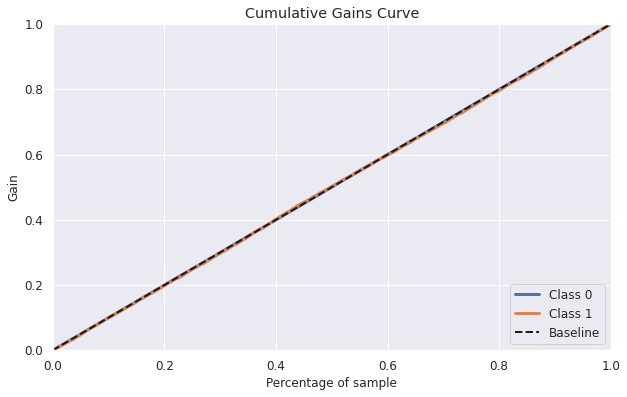

In [145]:
# Copy Data
df_baseline = df7.copy()

# propensity score
df_baseline['score'] = np.random.randint( 1, 101, df_baseline.shape[0] ) / 100
df_baseline['score1'] = -(df_baseline['score'] - 1)

# Model Prediction
yhat_baseline = df_baseline[['score', 'score1']].values


# Calculate and Print precision@k/recall@k
k = 20000
precision_k = precision_at_k( df_baseline, k=k )
print( f'Precision at {k}: {precision_k}' )

recall_k = recall_at_k( df_baseline, k=k )
print( f'Recall at {k}: {recall_k}' )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_baseline, figsize=(10, 6) );

# Single Performance Df
baseline_single = pd.DataFrame( {'Model Name': 'Baseline',
                             'PRECISION': round(precision_k, 4),
                             'RECALL': round(recall_k, 4)}, index=[0] )

In [146]:
baseline_cv = pd.DataFrame( {'Model Name': 'Baseline',
                             'PRECISION CV': str(round(precision_k, 4)),
                             'RECALL CV': str(round(recall_k, 4))}, index=[0] )
baseline_cv

,Model Name,PRECISION CV,RECALL CV
0,Baseline,0.1258,0.2674


## 7.1 KNN

Precision at 20000: 0.29373531323433827
Recall at 20000: 0.6241368320407946


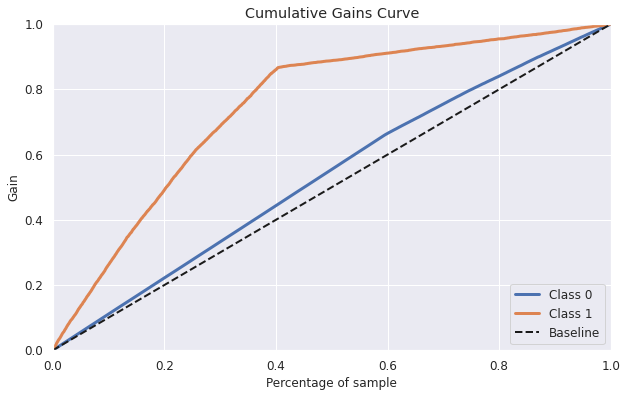

In [147]:
# Model Definition 
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# Model Training
knn_model.fit( x_train, y_train )

# Model Prediction 
yhat_knn = knn_model.predict_proba( x_val )

# Copy Data
df_knn = df7.copy()

# propensity score
df_knn['score'] = yhat_knn[:, 1].tolist()

# Calculate and Print precision@k/recall@k
k = 20000
precision_k = precision_at_k( df_knn, k=k )
print( f'Precision at {k}: {precision_k}' )

recall_k = recall_at_k( df_knn, k=k )
print( f'Recall at {k}: {recall_k}' )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, figsize=(10, 6) );

# Single Performance Df
knn_single = pd.DataFrame( {'Model Name': 'KNN',
                             'PRECISION': round(precision_k, 4),
                             'RECALL': round(recall_k, 4)}, index=[0] )

### 7.1.1 KNN Model - Cross Validation

In [148]:
knn_cv = cross_validation( x_training, 5, 'KNN', knn_model, 20000 )
knn_cv

,Model Name,PRECISION CV,RECALL CV
0,KNN,0.2911 +/- 0.0347,0.7801 +/- 0.0889


## 7.2 Logistic Regression

Precision at 20000: 0.2887855607219639
Recall at 20000: 0.613619462445554


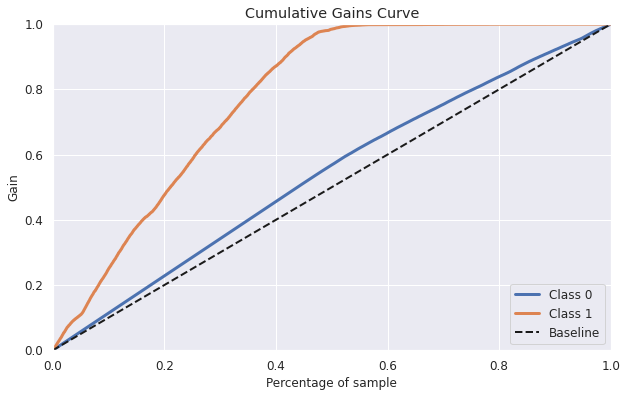

In [149]:
# Model Definition
lr_model = lm.LogisticRegression( random_state=42 )

# Model Training
lr_model.fit( x_train, y_train )

# Model Prediction
yhat_lr = lr_model.predict_proba( x_val )

# Copy Data
df_lr = df7.copy()

# propensity score
df_lr['score'] = yhat_lr[:, 1].tolist()

# compute precision@k/recall@k
k = 20000
precision_k = precision_at_k( df_lr, k=k )
print( f'Precision at {k}: {precision_k}' )

recall_k = recall_at_k( df_lr, k=k )
print( f'Recall at {k}: {recall_k}' )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr, figsize=(10, 6) );

# Single Performance Df
lr_single = pd.DataFrame( {'Model Name': 'Logistic Regression',
                             'PRECISION': round(precision_k, 4),
                             'RECALL': round(recall_k, 4)}, index=[0] )

### 7.2.1 Logistic Regression Model - Cross Validation

In [150]:
lr_cv = cross_validation( x_training, 5, 'Logistic Regression', lr_model, 20000 )
lr_cv

,Model Name,PRECISION CV,RECALL CV
0,Logistic Regression,0.2761 +/- 0.0021,0.7402 +/- 0.0076


## 7.3 Random Forest

Precision at 20000: 0.30703464826758664
Recall at 20000: 0.6523956230744715


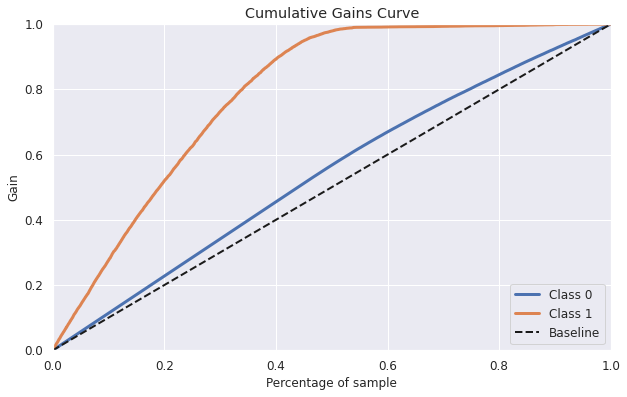

In [151]:
# Model Definition
rf_model = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 )

# Model Training
rf_model.fit( x_train, y_train )

# Model Prediction
yhat_rf = rf_model.predict_proba( x_val )

# Copy Data
df_rf = df7.copy()

# propensity score
df_rf['score'] = yhat_rf[:, 1].tolist()

# compute precision@k/recall@k
k = 20000
precision_k = precision_at_k( df_rf, k=k )
print( f'Precision at {k}: {precision_k}' )

recall_k = recall_at_k( df_rf, k=k )
print( f'Recall at {k}: {recall_k}' )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf, figsize=(10, 6) );

# Single Performance Df
rf_single = pd.DataFrame( {'Model Name': 'Random Forest',
                             'PRECISION': round(precision_k, 4),
                             'RECALL': round(recall_k, 4)}, index=[0] )

### 7.3.1 Random Forest Model - Cross Validation

In [152]:
rf_cv = cross_validation( x_training, 5, 'Random Forest', rf_model, 20000 )
rf_cv

,Model Name,PRECISION CV,RECALL CV
0,Random Forest,0.3082 +/- 0.0341,0.8261 +/- 0.087


## 7.4 XGBoost

In [180]:
xgb_model111 = XGBClassifier( objective='rank:pairwise', 
                               gamma= 3,
                               learning_rate=0.1,
                               n_estimators=100,
                               eta=0.3, 
                               max_depth=10, 
                               min_child_weight= 15 )

Precision at 20000: 0.3323833808309585
Recall at 20000: 0.7062573037288856


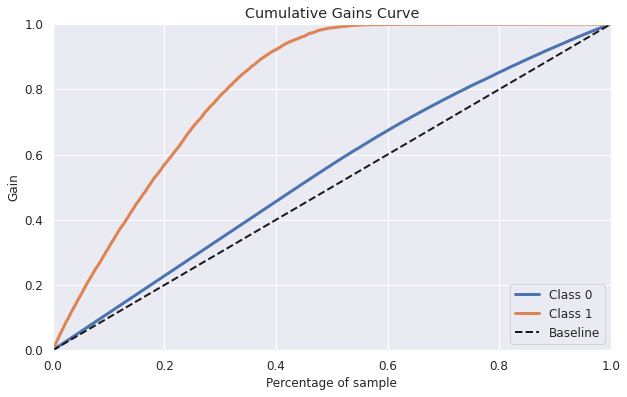

In [199]:
# Model Definition
xgb_model = XGBClassifier( objective='rank:pairwise' )

# Model Training
xgb_model.fit( x_train, y_train )

# Model Prediction
yhat_xgb = xgb_model.predict_proba( x_val )

# Copy Data
df_xgb = df7.copy()

# propensity score
df_xgb['score'] = yhat_xgb[:, 1].tolist()

# compute precision@k/recall@k
k = 20000
precision_k = precision_at_k( df_xgb, k=k )
print( f'Precision at {k}: {precision_k}' )

recall_k = recall_at_k( df_xgb, k=k )
print( f'Recall at {k}: {recall_k}' )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb, figsize=(10, 6) );

# Single Performance Df
xgb_single = pd.DataFrame( {'Model Name': 'XGBoost',
                             'PRECISION': round(precision_k, 4),
                             'RECALL': round(recall_k, 4)}, index=[0] )

### 7.4.1 XGBoost Model - Cross Validation

In [200]:
xgb_cv = cross_validation( x_training, 5, 'XGBoost', xgb_model, 20000 )
xgb_cv

,Model Name,PRECISION CV,RECALL CV
0,XGBoost,0.3106 +/- 0.004,0.8327 +/- 0.0059


## 7.5 Compare Model's Performance

### 7.5.1 Single Performance

In [155]:
models_result1 = pd.concat( [baseline_single, knn_single, lr_single, rf_single, xgb_single] )
models_result1.sort_values( 'RECALL', ascending=False )

,Model Name,PRECISION,RECALL
0,XGBoost,0.3296,0.7003
0,Random Forest,0.3070,0.6524
0,KNN,0.2937,0.6241
0,Logistic Regression,0.2888,0.6136
0,Baseline,0.1258,0.2674


### 7.5.2 Real Performance - Cross Validation

In [201]:
models_result = pd.concat( [baseline_cv, knn_cv, lr_cv, rf_cv, xgb_cv] )
models_result.sort_values( 'RECALL CV', ascending=False )

,Model Name,PRECISION CV,RECALL CV
0,XGBoost,0.3106 +/- 0.004,0.8327 +/- 0.0059
0,Random Forest,0.3082 +/- 0.0341,0.8261 +/- 0.087
0,KNN,0.2911 +/- 0.0347,0.7801 +/- 0.0889
0,Logistic Regression,0.2761 +/- 0.0021,0.7402 +/- 0.0076
0,Baseline,0.1258,0.2674


# 8.0 STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [168]:
param = { 'gamma': [1, 3, 5], 
          'eta': [0.3], 
          'max_depth': [3, 5, 6, 10, 15, 20], 
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'subsample': [0.1, 0.5, 1.0], 
          'colsample_bytree': [0.1, 0.4, 1.0], 
          'min_child_weight': [8, 15, 20], 
          'n_estimators': [100, 500, 1000]}

MAX_EVAL = 100

In [191]:
# final_result = pd.DataFrame()
# for i in range( MAX_EVAL ):
#     print( f'Iteration Procces: {i}/{MAX_EVAL}' )
#     # Choose values for parameters randomly
#     hp = { k: r.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
    
#     # Model
#     xgb_model = XGBClassifier( objective='rank:pairwise',  
#                                   eta=hp['eta'],
#                                   gamma=hp['gamma'],
#                                   max_depth=hp['max_depth'],
#                                   learning_rate=hp['learning_rate'],
#                                   subsample=hp['subsample'], 
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'],
#                                   n_estimators=hp['n_estimators'])
#     # Model Training
#     xgb_model.fit( x_train, y_train )
    
#     # Model Prediction
#     yhat_xgb = xgb_model.predict_proba( x_val )
    
#     dataframe_xgb = df7.copy()
    
#     # propensity score
#     df_xgb['score'] = yhat_xgb[:, 1].tolist()
    
#     # compute precision@k/recall@k
#     k = 20000
#     precision_k = precision_at_k( df_xgb, k=k )
#     print( f'Precision at {k}: {precision_k}' )

#     recall_k = recall_at_k( df_xgb, k=k )
#     print( f'Recall at {k}: {recall_k}' )
    
#     result = pd.DataFrame( {'iteration': i,
#                             'precision_at_k': precision_k,
#                             'recall_at_k': recall_k}, index=[0] )
#     final_result = pd.concat( [final_result, result] )
    
#     print( '=======================================' )

## 8.2 Final Model

In [127]:
# Best parameters values by first random search
# {'gamma': 1, 'eta': 0.3, 'max_depth': 8, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
# Precision at 30000: 0.2839905336488784
# Recall at 30000: 0.9165232358003442

In [ ]:
# Best parameters values by second random search
# {'gamma': 3, 'eta': 0.3, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 1.0, 'min_child_weight': 8, 'n_estimators': 1000}
# Precision at 20000: 0.33503324833758313
# Recall at 20000: 0.7118878147243174

In [184]:
# First Random Search
param_tuned = {'gamma': 1,
               'eta': 0.3,
               'max_depth': 8,
               'subsample': 0.7,
               'colsample_bytree': 0.7,
               'min_child_weight': 15}

In [196]:
# Second Random Search
param_tuned = {'gamma': 3,
               'eta': 0.3,
               'max_depth': 10,
               'learning_rate': 0.01,
               'subsample': 0.5,
               'colsample_bytree': 1.0,
               'min_child_weight': 8,
               'n_estimators': 1000}

In [198]:
# # Model Definition
# xgb_model_tunned = XGBClassifier( objective='rank:pairwise', 
#                                gamma=param_tuned['gamma'], 
#                                eta=param_tuned['eta'], 
#                                max_depth=param_tuned['max_depth'],
#                                learning_rate=param_tuned['learning_rate'],
#                                subsample=param_tuned['subsample'],
#                                colsample_bytree=param_tuned['colsample_bytree'],
#                                min_child_weight=param_tuned['min_child_weight'],
#                                n_estimators=param_tuned['n_estimators'])

# # Model Training
# xgb_model_tunned.fit( x_train, y_train )

# # Model Prediction
# yhat_xgb = xgb_model_tunned.predict_proba( x_val )

# # Copy Data
# df_xgb = df7.copy()

# # propensity score
# df_xgb['score'] = yhat_xgb[:, 1].tolist()

# # compute precision@k/recall@k
# k = 20000
# precision_k = precision_at_k( df_xgb, k=k )
# print( f'Precision at {k}: {precision_k}' )

# recall_k = recall_at_k( df_xgb, k=k )
# print( f'Recall at {k}: {recall_k}' )

# # Accumulative Gain
# skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb, figsize=(10, 6) );

## 8.3 Save Model

Precision at 20000: 0.33503324833758313
Recall at 20000: 0.7118878147243174


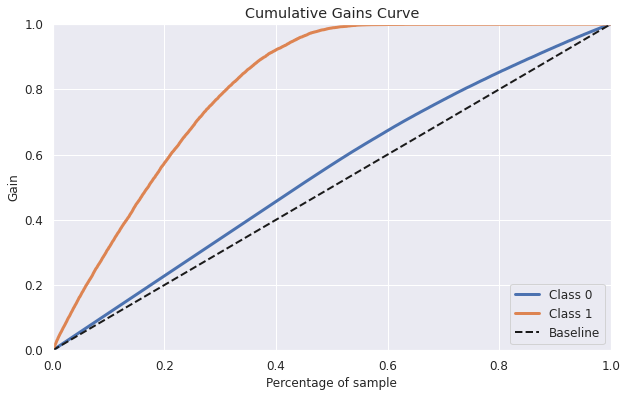

In [188]:
# Save Model
# pickle.dump( xgb_model_tunned, open( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/model/model_cross_sell.pkl', 'wb' ) )

# Load Model
xgb_model_tunned = pickle.load( open( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/model/model_cross_sell.pkl', 'rb' ) )

# Model Prediction
yhat_xgb_tunned = xgb_model_tunned.predict_proba( x_val )

# Copy Data
df_xgb = df7.copy()

# propensity score
df_xgb['score'] = yhat_xgb_tunned[:, 1].tolist()

# compute precision@k/recall@k
k = 20000
precision_k = precision_at_k( df_xgb, k=k )
print( f'Precision at {k}: {precision_k}' )

recall_k = recall_at_k( df_xgb, k=k )
print( f'Recall at {k}: {recall_k}' )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb_tunned, figsize=(10, 6) );

In [193]:
xgb_cv_tunned = cross_validation( x_training, 5, 'XGBoost Tunned', xgb_model_tunned, 20000 )
xgb_cv_tunned

,Model Name,PRECISION CV,RECALL CV
0,XGBoost Tunned,0.3117 +/- 0.0058,0.8358 +/- 0.0111


# 9.0 STEP 09 - ERROR TRANSLATION AND INTERPRETATION

In [131]:
df9 = df_xgb.copy()
df9 = df9.sort_values( by='score', ascending=False )

## 9.1 Total Performance

In [132]:
# Create revenue columns
df9['model_revenue'] = df9['response'].apply( lambda x: 1900 if x == 1 else -100 )
revenue_list = [1900, -100]
revenue_list1 = r.choices( revenue_list, weights=(12, 88), k=len(df9) )
df9['baseline_revenue'] = revenue_list1

# Create cumsum columns
df9['model_cumsum'] = df9['model_revenue'].cumsum()
df9['baseline_cumsum'] = df9['baseline_revenue'].cumsum()

# Create Count Column
df9['count'] = np.arange( len(df9) ) + 1

# Graph Axis and Lines
x = df9['count'].to_numpy()
y = df9['model_cumsum'].to_numpy()
z = df9['baseline_cumsum'].to_numpy()
x1 = np.array(list(df9.loc[df9.response == 1, 'count'].tail(1)))
y1 = np.array([df9.loc[df9['count'] == int(df9.loc[df9.response == 1, 'count'].tail(1)), 'model_cumsum']])
y2 = np.array([df9.loc[df9['count'] == int(df9.loc[df9.response == 1, 'count'].tail(1)), 'baseline_cumsum']])

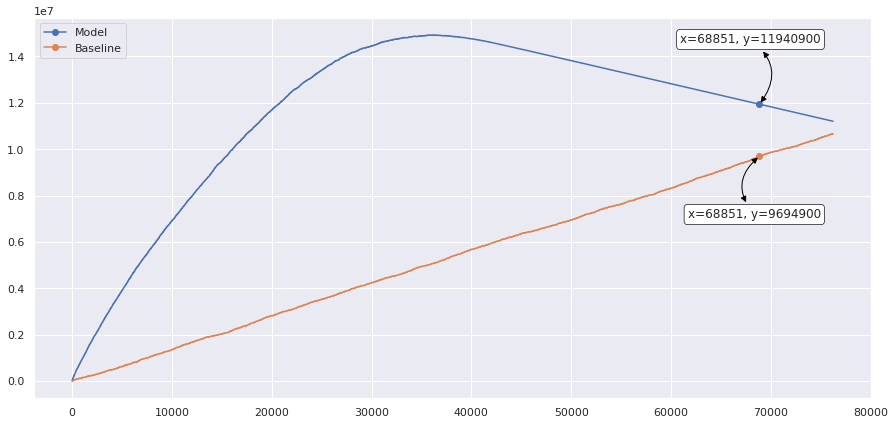

In [133]:
# Create Graph
fig, ax = plt.subplots()
markers_on = list(df9.loc[df9.response == 1, 'count'].tail(1))
ax.plot(x, y, label='Model', marker='o', markevery=markers_on)
ax.plot(x, z, label='Baseline', marker='o', markevery=markers_on)


xy = (0.94,0.96)
annot_max(x1,y1, xy)
xy = (0.94,0.50)
annot_max(x1,y2, xy)

plt.legend(loc='upper left')
plt.show()

## 9.2 Maximize Profit Efficiency

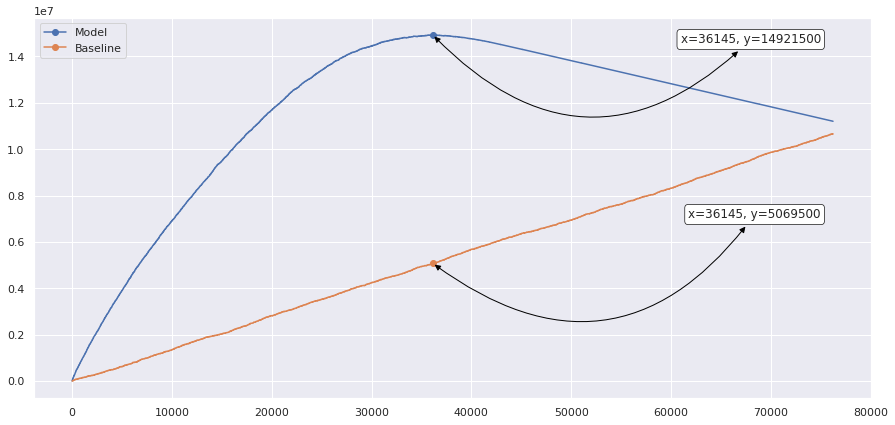

In [134]:
# Create Graph
x1 = np.array([x[np.argmax(y)]])
y1 = np.array([df9.loc[df9['count'] == int(x[np.argmax(y)]), 'baseline_cumsum']])

fig, ax = plt.subplots()
markers_on = [x[np.argmax(y)]]
ax.plot(x, y, label='Model', marker='o', markevery=markers_on)
ax.plot(x, z, label='Baseline', marker='o', markevery=markers_on)



xy = (0.94,0.96)
annot_max(x,y, xy)
xy = (0.94,0.50)
annot_max(x1,y1, xy)

plt.legend(loc='upper left')
plt.show()

## 9.3 Profit By Campaign Calls Capacity

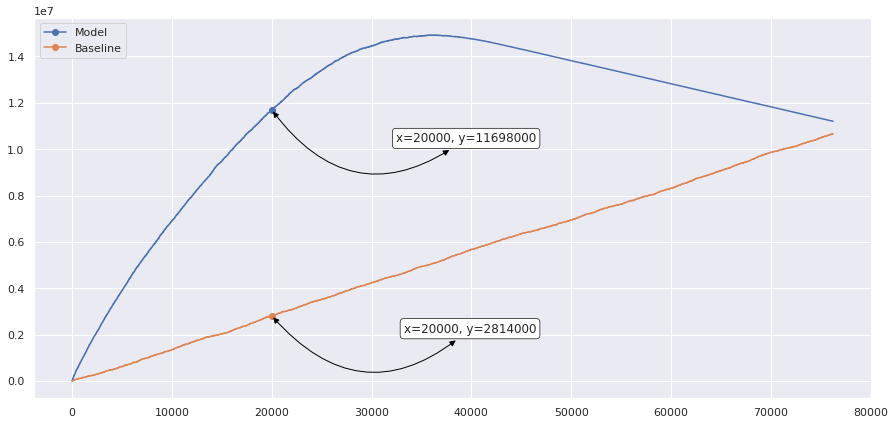

In [135]:
# Create Graph
x2 = np.array([20000])
y2 = np.array([int(df9.loc[df9['count'] == 20000, 'model_cumsum'])])
x1 = np.array([20000])
y1 = np.array([int(df9.loc[df9['count'] == 20000, 'baseline_cumsum'])])

fig, ax = plt.subplots()
markers_on = [20000]
ax.plot(x, y, label='Model', marker='o', markevery=markers_on)
ax.plot(x, z, label='Baseline', marker='o', markevery=markers_on)



xy = (0.60,0.70)
annot_max(x2,y2, xy)
xy = (0.60,0.20)
annot_max(x1,y1, xy)

plt.legend(loc='upper left')
plt.show()

# 10.0 STEP 10 - DEPLOY TO PRODUCTION

## 10.1 Create Model Class

In [136]:
import pickle
import pandas as pd
import numpy as np

class HealthInsurance( object ):
    def __init__( self ):
        self.home_path = '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/'
        self.annual_premium_scaler = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) )
        self.vintage_scaler = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) )
        self.target_encoding_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encoding_region_code_scaler.pkl', 'rb' ) )
        self.target_encode_gender_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler = pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        ## 1.6 Change Types

        df1['region_code'] = df1['region_code'].astype( int )

        # Check Change
        df1['region_code'].dtypes

        ## 1.7 Drop Columns

        if 'id.1'  in df1.columns:
            df1 = df1.drop( columns='id.1' )
        else:
            pass

        if 'id.2'  in df1.columns:
            df1 = df1.drop( columns='id.2' )
        else:
            pass

        return df1

    def feature_engineering( self, df2 ):
        # vehicle_damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # vehicle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'below_1_year' if x == '< 1 Year' else 
                                                                 'between_1_2_year' if x == '1-2 Year' else 
                                                                 'over_2_years' )
    
        return df2

    def data_preparation( self, df5 ):
        # Annual Premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        ## 5.2 Rescaling 

        # Age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        ## 5.3 Encoder

        # region_code - target encoding / frequency encoding / weighted target encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encoding_region_code_scaler )

        # Gender - One Hot encoding / Target encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # vehicle_age - one hot encoding / frequency encoding / order encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target encoding / frequency encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )

        # 6.0 STEP 06 - FEATURE SELECTION
        cols_selected = [ 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured' ]
    
        return df5[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):
        # Model Prediction
        pred = model.predict_proba( test_data )
        
        # Join Predicton into Original Data
        original_data['prediction'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [137]:
# import os
# import pickle
# import pandas as pd
# from flask import Flask, request, Response
# from healthinsurance.HealthInsurance import HealthInsurance

# # Loading Model
# path = '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/'
# model = pickle.load( open(path + 'model/model_cross_sell.pkl', 'rb') )

# # Initialize API
# app = Flask( __name__ )
# @app.route( '/predict', methods=['POST'] )

# def health_insurance_predict():
#     test_json = request.get_json()
    
#     if test_json: # there is data
#         if isinstance( test_json, dict ): # unique example
#             test_raw = pd.DataFrame( test_json, index=[0] )
            
#         else: # multiple example
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
#         # Instantiate HealthInsurance Class
#         pipeline = HealthInsurance()
        
#         # Data Cleaning
#         df1 = pipeline.data_cleaning( test_raw )
        
#         # Feature Engeneering
#         df2 = pipeline.feature_engineering( df1 )
        
#         # Data Preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         # Model Prediction
#         df_response = pipeline.get_prediction( model, test_raw, df3 )
        
#         return df_response
    
#     else:
#         return Response( '{}', status=200, mimetype='application/json' )
        
    
# if __name__ == '__main__':
#     port = os.environ.get( 'PORT', 5000 )
#     app.run( '0.0.0.0', debug=True )

## 10.3 API Tester

In [138]:
import requests
import json

In [139]:
# Load Test Dataset
df_test = x_validation

df_test = df_test.sample( 10 )

In [204]:
df_test2 = pd.read_csv( '/home/jeffsmedines/repos/pa4/health_insurance_cross_sell/data/validation/validation.csv' )

In [205]:
df_test2.head()

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,89740,1,59853.0,269,Female,76,41,26.0,1,between_1_2_year,0
1,99151,0,29655.0,234,Female,45,47,154.0,1,between_1_2_year,1
2,285991,1,24780.0,25,Female,26,47,152.0,1,below_1_year,0
3,171851,1,18362.0,79,Male,22,12,152.0,1,below_1_year,0
4,219271,1,29160.0,111,Female,28,11,152.0,1,below_1_year,0


In [140]:
df_test

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
235392,355494,0,-1.632547,0.214533,0.137834,0.246154,0.113916,0.017659,1,1,0,1,0
269100,244431,1,-0.328107,0.211073,0.137834,0.123077,0.073310,0.353629,1,0,1,0,0
201033,80805,1,-1.632547,0.930796,0.137834,0.923077,0.101208,0.002345,1,0,0,1,0
211851,167360,1,-0.009713,0.480969,0.104082,0.184615,0.097970,0.194383,1,0,0,1,0
304587,147710,0,0.304764,0.290657,0.137834,0.846154,0.095549,0.017659,1,1,0,0,1
284352,366437,0,0.090241,0.965398,0.104082,0.830769,0.187614,0.208795,1,1,0,0,1
198882,63725,1,-0.336817,0.702422,0.104082,0.200000,0.102456,0.057080,1,0,1,0,0
351191,141847,1,1.809932,0.543253,0.104082,0.676923,0.187614,0.208795,1,0,0,1,0
316542,243086,0,-0.176129,0.982699,0.137834,0.369231,0.126367,0.194383,1,1,0,1,0
106827,90630,0,0.597848,0.311419,0.137834,0.646154,0.187614,0.208795,1,1,0,1,0


In [209]:
# Convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [210]:
# API Call
url = 'https://cross-sell-predict-application.onrender.com/predict'
# url = 'http://127.0.0.1:5000/predict'

header = { 'Content-type': 'application/json' }


r = requests.post( url, data=data, headers=header )
print( f'Status Code {r.status_code}' )

Status Code 200


In [211]:
data

'[{"id": 355494, "previously_insured": 0, "annual_premium": -1.6325467968598497, "vintage": 0.21453287197231835, "gender": 0.1378341816152339, "age": 0.24615384615384617, "region_code": 0.113915857605178, "policy_sales_channel": 0.01765900153171503, "driving_license": 1, "vehicle_damage": 1, "vehicle_age_below_1_year": 0, "vehicle_age_between_1_2_year": 1, "vehicle_age_over_2_years": 0}, {"id": 244431, "previously_insured": 1, "annual_premium": -0.3281074530635462, "vintage": 0.2110726643598616, "gender": 0.1378341816152339, "age": 0.12307692307692308, "region_code": 0.07331018991219114, "policy_sales_channel": 0.3536293774414783, "driving_license": 1, "vehicle_damage": 0, "vehicle_age_below_1_year": 1, "vehicle_age_between_1_2_year": 0, "vehicle_age_over_2_years": 0}, {"id": 80805, "previously_insured": 1, "annual_premium": -1.6325467968598497, "vintage": 0.9307958477508651, "gender": 0.1378341816152339, "age": 0.9230769230769231, "region_code": 0.10120805369127517, "policy_sales_chan